### Load Libraries

In [1]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import io
import os
import timeit
import pickle

import scipy.sparse as sp

### Read Rating Matrix NDB_MPD

In [2]:
sparse_matrix = sp.load_npz('./data/matrix_playlistTrackRating_ndb.npz')

In [3]:
sparse_matrix

<279032x1124914 sparse matrix of type '<class 'numpy.int8'>'
	with 23545215 stored elements in Compressed Sparse Row format>

In [4]:
num_playlists = sparse_matrix.shape[0]
num_tracks = sparse_matrix.shape[1]
num_rates = num_tracks = sparse_matrix.nnz
print('There are {} unique playlists and {} unique tracks with {} rates in NDB_MPD SparseMatrix'.format(num_playlists, num_tracks, num_rates))

There are 279032 unique playlists and 23545215 unique tracks with 23545215 rates in NDB_MPD SparseMatrix


In [5]:
ratings_df = pd.DataFrame({'pid': sparse_matrix.tocoo().row, 
                           'tid': sparse_matrix.tocoo().col, 
                           'rate': sparse_matrix.tocoo().data})

In [6]:
ratings_df

,pid,tid,rate
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
23545210,279031,1745,1
23545211,279031,36450,1
23545212,279031,29925,1
23545213,279031,4591,1


### Filter Data

In [7]:
# Rating frequency
df_tracks_cnt = pd.DataFrame(ratings_df.groupby('tid').size(), columns=['count'])
df_tracks_cnt.head()

,count
tid,
0,7678
1,2
2,1
3,1
4,8


### 1) Filter tracks having a minimum of 10 rates

In [37]:
df_tracks_cnt['count'].quantile(np.arange(1, 0.85, -0.01))

1.00    19393.0
0.99      323.0
0.98      145.0
0.97       87.0
0.96       60.0
0.95       45.0
0.94       35.0
0.93       28.0
0.92       24.0
0.91       20.0
0.90       17.0
0.89       15.0
0.88       13.0
0.87       12.0
0.86       11.0
0.85       10.0
Name: count, dtype: float64

In [38]:
popularity_thres = 10
popular_tracks = list(set(df_tracks_cnt.query('count >= @popularity_thres').index))

In [39]:
len(popular_tracks)

170148

In [40]:
ratings_drop_tracks_df = ratings_df[ratings_df.tid.isin(popular_tracks)]
print('shape of original ratings data: ', ratings_df.shape)
print('shape of ratings data after dropping unpopular tracks: ', ratings_drop_tracks_df.shape)

shape of original ratings data:  (23545215, 3)
shape of ratings data after dropping unpopular tracks:  (21520018, 3)


In [44]:
tracks_filter_cut = len(popular_tracks)

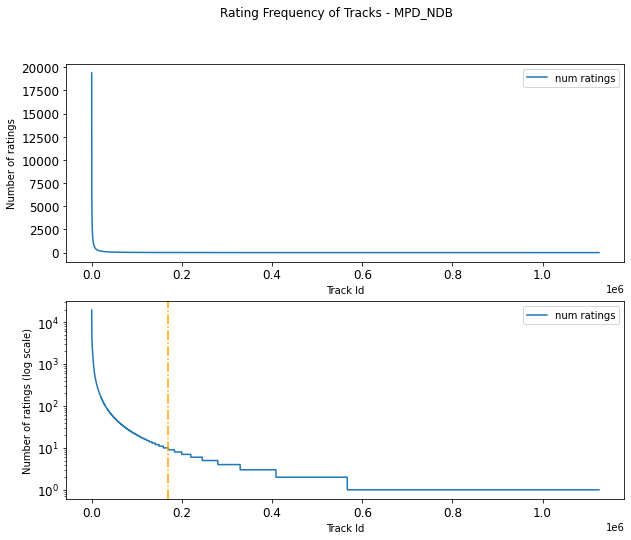

In [70]:
# Plot: Rating frequency tracks

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Rating Frequency of Tracks - MPD_NDB')

ax1 = df_tracks_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(10, 8),
        fontsize=12,
        ax=axes[0]
    )
ax1.set_xlabel("Track Id")
ax1.set_ylabel("Number of ratings")
L1=ax1.legend() 
L1.get_texts()[0].set_text('num ratings')

ax2 = df_tracks_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(10, 8),
        fontsize=12,
        logy=True,
        ax=axes[1]     
    )
ax2.set_xlabel("Track Id")
ax2.set_ylabel("Number of ratings (log scale)")
ax2.axvline(x=tracks_filter_cut, color='orange', linestyle='dashdot')
L2=ax2.legend()
L2.get_texts()[0].set_text('num ratings')

In [78]:
fig.savefig('./visualization/Rating Frequency of Tracks - MPD_NDB.png')

In [47]:
# get number of tracks per playlist
playlists_cnt_df = pd.DataFrame(ratings_drop_tracks_df.groupby('pid').size(), columns=['count'])
playlists_cnt_df.sort_values(by='count', ascending=False)

,count
pid,
90028,250
258076,250
163876,250
195246,250
237628,249
...,...
32310,1
14033,1
75825,1


### 2) Filter playlists having a minimum length of 50 tracks on it

In [48]:
playlists_cnt_df['count'].quantile(np.arange(1, 0.1, -0.05))

1.00    250.0
0.95    187.0
0.90    158.0
0.85    138.0
0.80    121.0
0.75    108.0
0.70     97.0
0.65     87.0
0.60     78.0
0.55     70.0
0.50     63.0
0.45     57.0
0.40     51.0
0.35     45.0
0.30     40.0
0.25     35.0
0.20     30.0
0.15     25.0
Name: count, dtype: float64

In [49]:
# filter data
ratings_thres = 50
long_playlists = list(set(playlists_cnt_df.query('count >= @ratings_thres').index))
ratings_drop_playlists_df = ratings_drop_tracks_df[ratings_drop_tracks_df.pid.isin(long_playlists)]
print('shape of original ratings data: ', ratings_df.shape)
print('shape of ratings data after dropping both; unpopular tracks and short playlists: ', ratings_drop_playlists_df.shape)

shape of original ratings data:  (23545215, 3)
shape of ratings data after dropping both; unpopular tracks and short playlists:  (18378358, 3)


In [50]:
# Number of Playlists after dropping

ratings_drop_playlists_df.pid.nunique()

171069

In [51]:
# Number of Tracks after dropping

ratings_drop_playlists_df.tid.nunique()

170117

In [52]:
playlists_filter_cut = ratings_drop_playlists_df.pid.nunique()

In [65]:
playlists_cnt_df

,count
pid,
0,32
1,75
2,34
3,46
4,106
...,...
279027,123
279028,173
279029,94


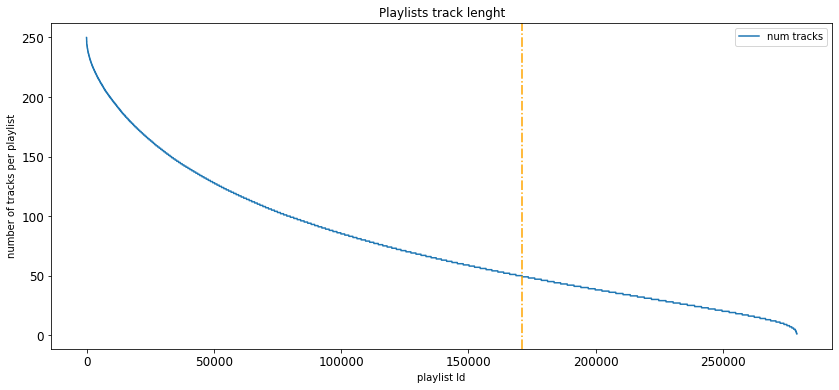

In [76]:
# Plot: number of tracks by Playlists in MPD_NDB

ax = playlists_cnt_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(14, 6),
        title='Playlists track lenght',
        fontsize=12
    )
ax.set_xlabel("playlist Id")
ax.set_ylabel("number of tracks per playlist")
ax.axvline(x=playlists_filter_cut, color='orange', linestyle='dashdot')
L=ax.legend()
L.get_texts()[0].set_text('num tracks')

In [79]:
ax.figure.savefig('./visualization/Filter by playlist length - threshold 50.png')

### Create Dict mapping to original index (pid and tid)  
* Use it before reset_index

In [87]:
# List original pid from MPD_NDB dataset
mpdNDB_pid_list = list(ratings_df.pid.unique())

In [88]:
len(mpdNDB_pid_list)

279032

In [89]:
# List of pid Subset_mpdNDB 
subset_mpdNDB_pid_list = list(ratings_drop_playlists_df.pid.unique())

In [90]:
len(subset_mpdNDB_pid_list)

171069

In [91]:
# List of Deleted pid from MPD_NDB dataset
del_pid_list = list(set(mpdNDB_pid_list) - set(subset_mpdNDB_pid_list))

In [92]:
len(del_pid_list)

107963

In [93]:
# Dict to map original pid at mpdNDB dataset (pid) with new (index) at subset_mpdNDB
# Dict {key:value} --> {old_pid:newpid}

new_pid_index = {pid: index for index, pid in enumerate(subset_mpdNDB_pid_list, start=0)}

In [94]:
# Last 10 elements at new_pid_index Dict

pidIDs = [ (key, value) for key, value in new_pid_index.items() if value in range(len(new_pid_index)-10,len(new_pid_index))]
pidIDs

[(279019, 171059),
 (279020, 171060),
 (279021, 171061),
 (279023, 171062),
 (279025, 171063),
 (279026, 171064),
 (279027, 171065),
 (279028, 171066),
 (279029, 171067),
 (279031, 171068)]

In [95]:
# List original tid from MPD_NDB dataset
mpdNDB_tid_list = list(ratings_df.tid.unique())

In [96]:
len(mpdNDB_tid_list)

1124914

In [97]:
# List of tid in Subset_mpdNDB 
subset_mpdNDB_tid_list = list(ratings_drop_playlists_df.tid.unique())

In [99]:
len(subset_mpdNDB_tid_list)

170117

In [100]:
# List of Deleted tid from MPD_NDB dataset
del_tid_list = list(set(mpdNDB_tid_list) - set(subset_mpdNDB_tid_list))

In [101]:
len(del_tid_list)

954797

In [102]:
# Dict to map original tid at mpdNDB dataset (tid) with new (index) at subset_mpdNDB
# Dict {key:value} --> {old_tid:new_tid}

new_tid_index = {tid: index for index, tid in enumerate(subset_mpdNDB_tid_list, start=0)}

In [103]:
# Last 10 elements at new_tid_index Dict

tidIDs = [ (key, value) for key, value in new_tid_index.items() if value in range(len(new_tid_index)-10,len(new_tid_index))]
tidIDs

[(143321, 170107),
 (159446, 170108),
 (501713, 170109),
 (723864, 170110),
 (356430, 170111),
 (141057, 170112),
 (141059, 170113),
 (696494, 170114),
 (285191, 170115),
 (286426, 170116)]

### Reset indexes at subset_mpdNDB dataset

In [104]:
subset_mpdNDB = ratings_drop_playlists_df.reset_index(drop=True)

In [105]:
subset_mpdNDB['pid'] = subset_mpdNDB['pid'].apply(lambda x: new_pid_index[x])

In [106]:
subset_mpdNDB['tid'] = subset_mpdNDB['tid'].apply(lambda x: new_tid_index[x])

In [107]:
subset_mpdNDB

,pid,tid,rate
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
18378353,171068,1352,1
18378354,171068,160312,1
18378355,171068,22564,1
18378356,171068,3576,1


### Save Dicts in reverse order

In [108]:
old_pid_index = {v: k for k, v in new_pid_index.items()}

In [109]:
print(f"Save old_pid_index Dict pkl format")
pickle.dump(old_pid_index, open(f"./data/old_pid_index.pkl", "wb"))

Save old_pid_index Dict pkl format


In [110]:
old_tid_index = {v: k for k, v in new_tid_index.items()}

In [111]:
print(f"Save old_tid_index Dict pkl format")
pickle.dump(old_tid_index, open(f"./data/old_tid_index.pkl", "wb"))

Save old_tid_index Dict pkl format


### Convert Dataframe to sparse matrix in csr format

In [112]:
row_size = subset_mpdNDB.pid.nunique()
col_size = subset_mpdNDB.tid.nunique()
sp_data = subset_mpdNDB.rate
sp_rows = subset_mpdNDB.pid
sp_cols = subset_mpdNDB.tid
subset_mpdNDB_sparse_matrix = sp.csr_matrix((sp_data, (sp_rows, sp_cols)), shape=(row_size, col_size))

In [113]:
subset_mpdNDB_sparse_matrix

<171069x170117 sparse matrix of type '<class 'numpy.int8'>'
	with 18378358 stored elements in Compressed Sparse Row format>

In [114]:
sp.save_npz('./data/subset_mpdNDB_sparse_matrix.npz', subset_mpdNDB_sparse_matrix)